## Finding suspisuos activities

BuzzFeed and their partners recently released stories about a trove of almost 2,500 Suspicious Activity Reports (SARs) filed by banks with the Financial Crimes Enforcement Network (FinCEN) between 2000 and 2017. They included thousands of suspicious bank transactions totaling over $35B. In cooperation with BuzzFeed, the International Consortium of Investigative Journalists (ICIJ) published a dataset that includes detailed information on 4500 suspicious transactions. 

Try finding other suspiciously similar transactions using datasets listed below. You can use any tools/methods.

Importing libraries and data:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_2015 = pd.read_csv('2015.csv')
df_2016 = pd.read_csv('2016.csv')
df_2017 = pd.read_csv('2017.csv')

In [3]:
df_2015.head(3)

,time,Sender,Receiver,Transaction_amount,Price,Transaction_amount_USD
0,2015-04-01,14noyXsYSBTJYsyUmyDWhSeAVbge7qi5E3,1H8rsLPgFQ3kBU7WvRGDR8X9Pv1d5k3zQF,8811.015,243.288169,2.143616e+06
1,2015-04-01,1LHXyLdpKC52988BqFXCHksU11QvXM7qRT,14noyXsYSBTJYsyUmyDWhSeAVbge7qi5E3,8972.836,243.288169,2.182985e+06
2,2015-04-01,15Bu9gyGtGrXuoLDe3erKfTj7n15mAp1Wc\n1KYJV7JJDu...,1BsrvZgK11ZAsJYokFe9pAm3z58dodQLAr,5000.000,243.288169,1.216441e+06


In [4]:
print('2015 len:', df_2015.shape[0], '| 2016 len:', df_2016.shape[0], '| 2017 len:', df_2017.shape[0])

2015 len: 8107 | 2016 len: 43247 | 2017 len: 9783


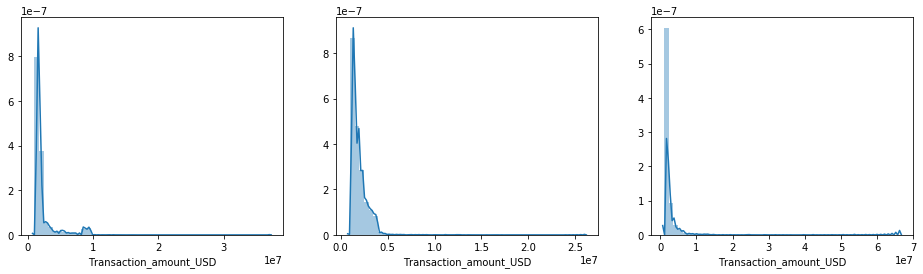

In [5]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

sns.distplot(df_2015['Transaction_amount_USD'], ax = axes[0])
sns.distplot(df_2016['Transaction_amount_USD'], ax = axes[1])
sns.distplot(df_2017['Transaction_amount_USD'], ax = axes[2])

plt.show()

In [6]:
bank_connections = pd.read_csv("download_bank_connections.csv")
transaction_map = pd.read_csv("download_transactions_map.csv")

### Preparing the data

#### Formatting for date columns:

In [7]:
dataset = [df_2015, df_2016, df_2017]

for data in dataset:
        data['time'] = pd.to_datetime(data['time'])

In [8]:
transaction_map['end_date'] = pd.to_datetime(transaction_map['end_date'])
transaction_map['year'] = transaction_map['end_date'].dt.year

# splitting data into three years
transaction_2015 = transaction_map[transaction_map['year'] == 2015] 
transaction_2016 = transaction_map[transaction_map['year'] == 2016]
transaction_2017 = transaction_map[transaction_map['year'] == 2017]

#### Removing mistakes:

There are some sender's adresses in the data that written incorrectly: they have '\n' symbol in the name (e.g. in data of 2017 there is an adress '3HsgcR8pC6MhCStG12LP5o2P8teQyRWgKm\n3GZxQQovrZxZe1wQ3qTGDhFxViiRiKB1uv\n3GtEDfrbcCZjTUfnJ7AZJKFfqTtMYoAXJW' (index 8453).    
So I just removed the symbol and everything that goes after it:

In [9]:
def delete(row):
    d = row.split('\n')[0]
    return d

In [10]:
for data in dataset:
    data['Sender'] = data['Sender'].apply(delete)

### Problem statement

#### The task is to match datasets and find suspiciously similar transactions. The search will be achieved through the comparison of dates and transfer amounts. For illustrative proposes I selected one month from a dataset and made a chart:

In [11]:
df_2015['month'] = df_2015['time'].dt.month
df_march = df_2015[df_2015['month'] == 3]
transaction_2015['month'] = transaction_2015['end_date'].dt.month
transaction_march = transaction_2015[transaction_2015['month'] == 3]

In [12]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_march.time,  y=df_march.Transaction_amount_USD, mode='markers', name = 'Blockchain transaction'))
fig.add_trace(go.Scatter(x=transaction_march.end_date,y= transaction_march.amount_transactions, mode='markers', name='Bank transaction'))
fig.update_layout(title = 'Visualisation of similar objects',
                  yaxis=dict(range=[-1000000,18000000]), 
                  yaxis_title="Amount")
fig.show()

You can see some overlapped dots, they mean transactions of similar amount and made in the same day. For example, there's one between March 15 and March 22. Probably it will be dedected as suspicious transaction.

### Finding suspicious activities

In order to solve the task I've written a function, which makes dataframe of all the suspicious transactions that were made in certain year:

In [13]:
def find_suspicious(bank_data, blockchain_data):

    """
    This function takes in input data of bank transactions and checks 
    if there's any similar transaction in blockchain dataset
    
    The function:
    
    1) makes empty lists where suspicious transactions will be added;
    
    2) filters blockchain data by date and transaction amount: 
       - the transaction has to be made in range of two days;
       - the deviation in amount is 0,5%.
       
    3) finds the most appropriate transaction by checking the difference (the least difference will be taken)
    and add the information to the lists
    
    4) makes dataframe of all detected transations from the lists.
    
    
    """
    transaction_bank_time = []
    transaction_blockchain_time = []
    sender = []
    receiver = []
    beneficiary_bank = []
    originator_bank = []
    amount_bank = []
    amount_blockchain = []
    
    for _, i in bank_data.iterrows():
        amount = i['amount_transactions']
        date = i['end_date']
        beneficiary = i['beneficiary_bank']
        originator = i['originator_bank']

        lower = amount * 0.995
        upper = amount * 1.005

        least_diff = 10000

        transactions = blockchain_data[(blockchain_data['Transaction_amount_USD'] >= lower) & 
                                       (blockchain_data['Transaction_amount_USD'] <= upper) & 
                                       (blockchain_data['time'] >= date - pd.DateOffset(days=2)) &
                                       (blockchain_data['time'] <= date)]
        
        for _, row in transactions.iterrows():
            diff = abs(i['amount_transactions'] - amount)
            if diff < least_diff:
                least_diff = diff
                sender.append(row['Sender'])
                receiver.append(row['Receiver'])
                amount_blockchain.append(row['Transaction_amount_USD'])
                transaction_blockchain_time.append(row['time'])

                beneficiary_bank.append(beneficiary)
                originator_bank.append(originator)
                transaction_bank_time.append(date)
                amount_bank.append(amount)
                    
    dict = {
        'transaction_bank_time': transaction_bank_time, 
        'transaction_blockchain_time': transaction_blockchain_time,
        'sender': sender,
        'receiver': receiver,
        'beneficiary_bank': beneficiary_bank,
        'originator_bank': originator_bank,
        'amount_bank': amount_bank,
        'amount_blockchain': amount_blockchain
                    }

    suspicious_transactions = pd.DataFrame(dict)
        
    return suspicious_transactions

In [14]:
suspicious_transactions_2015 = find_suspicious(transaction_2015, df_2015)
suspicious_transactions_2016 = find_suspicious(transaction_2016, df_2016)
suspicious_transactions_2017 = find_suspicious(transaction_2017, df_2017)

### 2015 activities

In [15]:
transaction_map[transaction_map['beneficiary_bank'] == 'Standard Chartered Bank']

,id,icij_sar_id,filer_org_name_id,filer_org_name,begin_date,end_date,originator_bank_id,originator_bank,originator_bank_country,originator_iso,beneficiary_bank_id,beneficiary_bank,beneficiary_bank_country,beneficiary_iso,number_transactions,amount_transactions,year
151,223615,4031,standard-chartered-plc,Standard Chartered Plc,"Oct 2, 2012",2013-04-05,public-bank-berhad,Public Bank Berhad,Malaysia,MYS,standard-chartered-bank-united-kingdom-gbr,Standard Chartered Bank,United Kingdom,GBR,7.0,13374849.28,2013.0
192,223847,3535,the-bank-of-new-york-mellon-corp,The Bank of New York Mellon Corp.,"Oct 23, 2008",2008-12-29,unicredit-bank-moscow-russia-rus,"UniCredit Bank (Moscow, Russia)",Russia,RUS,standard-chartered-bank-hong-kong-hkg,Standard Chartered Bank,Hong Kong,HKG,41.0,17519500.00,2008.0
439,224731,4145,the-bank-of-new-york-mellon-corp,The Bank of New York Mellon Corp.,"Sep 3, 2015",2015-09-03,banque-de-commerce-et-de-placements-s-a,Banque De Commerce Et De Placements S A,Switzerland,CHE,standard-chartered-bank-london-england-gbr,Standard Chartered Bank,United Kingdom,GBR,1.0,6000000.00,2015.0
441,224733,4145,the-bank-of-new-york-mellon-corp,The Bank of New York Mellon Corp.,"Sep 1, 2015",2015-09-10,dbs-bank,DBS Bank,China,CHN,standard-chartered-bank-hong-kong-hkg,Standard Chartered Bank,Hong Kong,HKG,7.0,68700000.00,2015.0
452,224810,4011,standard-chartered-plc,Standard Chartered Plc,"Feb 27, 2014",2014-07-11,national-australia-bank-limited,National Australia Bank Limited,Australia,AUS,standard-chartered-bank-hong-kong-hkg,Standard Chartered Bank,Hong Kong,HKG,5.0,4975.00,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3494,238698,3016,standard-chartered-plc,Standard Chartered Plc,"Oct 28, 2010",2010-10-28,fbme-bank-ltd,Fbme Bank Ltd,Cyprus,CYP,standard-chartered-bank-london-england-gbr,Standard Chartered Bank,United Kingdom,GBR,1.0,5250.00,2010.0
3495,238699,3016,standard-chartered-plc,Standard Chartered Plc,"Oct 17, 2013",2013-10-17,regionala-investiciju-banka,Regionala Investiciju Banka,Latvia,LVA,standard-chartered-bank-singapore-sgp,Standard Chartered Bank,Singapore,SGP,1.0,22856.40,2013.0
3497,238701,3016,standard-chartered-plc,Standard Chartered Plc,"May 22, 2012",2012-05-22,regionala-investiciju-banka,Regionala Investiciju Banka,Latvia,LVA,standard-chartered-bank-singapore-sgp,Standard Chartered Bank,Singapore,SGP,1.0,61516.89,2012.0
4055,240345,2376,the-bank-of-new-york-mellon-corp,The Bank of New York Mellon Corp.,"Nov 28, 2011",2011-11-28,first-sino-bank,First Sino Bank,China,CHN,standard-chartered-bank-hong-kong-hkg,Standard Chartered Bank,Hong Kong,HKG,1.0,1038700.00,2011.0


In [16]:
suspicious_transactions_2015

,transaction_bank_time,transaction_blockchain_time,sender,receiver,beneficiary_bank,originator_bank,amount_bank,amount_blockchain
0,2015-03-18,2015-03-18,18bntxdhKoWR8zJtX86ZyjcouyXuiHzaCw,1FfBG4nLgewUo7Z4hhGo5mAXQeGdgxjWbD,Credit Suisse AG,"UniCredit Bank, Cjsc",1762600.00,1.758541e+06
1,2015-09-11,2015-09-10,3Fb24RACH6wpgtyhdDB8sKZAPpyoXuUauw,33kMM2qRcPBve9UZCPGJHd87Ziq7v2fQKJ,Credit Suisse,China Merchants Bank,2860562.43,2.850727e+06
2,2015-09-03,2015-09-01,3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw,3GGf1p5PvCybMPwgbfgHyDzfmeMrJ6ajRD,Standard Chartered Bank,Banque De Commerce Et De Placements S A,6000000.00,6.013212e+06
3,2015-12-24,2015-12-22,3J6ai2repNTNSQvD41fEKRpCznoeQGs9v2,3LCTdKX27wWzNzhpey1t5NSAEniLAdtmgX,Kazkommertsbank,Trasta Komercbanka,1899974.00,1.900292e+06
4,2015-10-29,2015-10-28,3EKRFnJkRgCqFAN2qVXaAK4hP9UopsTD8u,3MJWZrYcEeEUX1QbDAWzGYKeKChQRMaTUC,Ping An Bank Co Ltd,SCSB Savings Department Branch,2993552.18,2.988099e+06
5,2015-08-18,2015-08-18,3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw,3N1jNyifuLweCgFjvehz6by43auYWGoCxS,Laishang Bank,DBS Bank,5973690.73,5.952913e+06
6,2015-03-13,2015-03-12,1PwGLzCHJypNGWwhosB8bzjEhjYeESbjtq,1AsqHeMEFTjtqtGRF9aFuwQXMAB6rrJ7Fp,Turkiye Finans Katilim Bankasi A.S.,Expobank,1250253.00,1.253431e+06
7,2015-03-19,2015-03-17,18RMgKSeJryawnTNDeYty4gZsqki8jQxwD,1LhxgRX4yLewcdwnyGwgHCHdNb5kgWLDkP,Turkiye Finans Katilim Bankasi A.S.,Expobank,1467500.00,1.466941e+06
8,2015-03-10,2015-03-08,1LhkCSsypLZzxiSMKaa7divSWWvgLJRjhv,1BzGDHaBKvxGRYw3Ayeq6nDkKg8MmJumJG,Credit Suisse AG,Expobank,1649757.00,1.651933e+06
9,2015-12-18,2015-12-17,3Dx3SuT8fnp9Q4AAzPgt3iuXP3Nhb7nLW8,32ZcBL379bDk9RsM7nyHcCPTkZtp4uDBJ4,Union Bancaire Privee,Kleinwort Benson,2053259.51,2.049563e+06


Some of the activities were seen from `3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw` adress, which was already observed in the task explanation. 
     
Here are some notes:     
      
- On Sep 3, 2015, $6 million were sent from Banque De Commerce Et De Placements (Switzerland) to Standard Chartered Bank (United Kingdom) and transfer of 6013212 were seen two days earlier between 3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw and 3GGf1p5PvCybMPwgbfgHyDzfmeMrJ6ajRD hashes. Standard Chartered is known to have low control on money laundering and was fined 1,1 bn dollars at 2019.    
     
- Sender 3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw moved 5973690.73 to 3N1jNyifuLweCgFjvehz6by43auYWGoCxS on August 18 and 5.952913 were sent from DBS Bank to Laishang Bank on the same day.      
     
- 1HoaEHSsMY2rtdYNFseKW9BTwsyb3XN9fB sent 2004228 dollars to 1ABjpHQbwuBHXJhzF8AeEmrZuD6Y231sYa on November, 11 and 2M dollars were also sent from United Overseas Bank Limited	to Citibank, N.A. two days earlier.

In [17]:
suspicious_transactions_2016

,transaction_bank_time,transaction_blockchain_time,sender,receiver,beneficiary_bank,originator_bank,amount_bank,amount_blockchain
0,2016-07-27,2016-07-27,33pqMFkwV89LJtd87BLVN4vQDjJMNhM1G8,3HeTL3L661oBXU4dh32CdgeGgqXsx9XNzR,Eurobank Cyprus Ltd,Bank of Cyprus Public Company Limited,3987992.00,3.996353e+06
1,2016-07-19,2016-07-17,3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw,3Gixb55dBPg5VrhhReUJqDKnf4rRs6s9cQ,International Invest Bank,AS Meridian Trade Bank,1792200.00,1.786099e+06
2,2016-06-22,2016-06-20,3NUWpmY235qquobcP9wHsr6Ny4uBkjrctp,15wyJrQFziqkrKMj3EHDMToTkXyRQfZxPL,Ukrsotzbank,AS Meridian Trade Bank,3733968.80,3.731537e+06
3,2016-06-21,2016-06-21,3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw,354uAYiXo83jd3qQMMDAerV3PrwpT5VQ4x,SCSB Savings Department Branch,Rizal Commercial Banking Corp,1836639.00,1.833035e+06
4,2016-06-20,2016-06-19,14RFzpS5JwNv7wTeTLRqEEQpAds6PmFXCu,143fCBGTZF455YzgdztNvkUdFm6qaBXvP7,JSC Norvik Banka,International Bank of St. Petersburg Plc,1586492.00,1.581633e+06
5,2016-06-07,2016-06-07,39EvwaBbstZmhg1Jbye7EEXDMnpFcDvKCR,3NCE5kvz6Spu4rCZnjy2myJytzbKuqGb1B,China Minsheng Banking Corp,Bank of Communications Co Ltd,2487862.59,2.486547e+06
6,2016-06-22,2016-06-21,3R2D7bZfqsFu2zUN4Rbm5k3cwiXw4yazYe,3PTZmaCQB2r2trTDPoMizR2Esk4wvbN71j,PPF Banka A.S.,Cyprus Development Bank Public,3128412.90,3.122793e+06
7,2016-01-19,2016-01-19,15QE4nFrvgwPkHyXyPaLy5W6xdp5f1Lr8F,1A6We7hfTFUNbP3ktNz8mjV7MRTd9wBWN7,Saigon Thuong Tin Commercial Joint Stock Bank,Bank of China,1000000.00,1.003393e+06
8,2016-05-25,2016-05-25,18Pd8pLcC2H95owuBjaR1VW2UnsnWuRM1Z,1PY2AGmMoT59McbgcA87tcp5wdWgTCJ4tu,Banque Pour Le Commerce Exterieur Lao Public,Bank of China,1388230.00,1.382564e+06
9,2016-11-24,2016-11-23,17hmKSU5SKxJYsdKiEeRLmNYLaCjgMuGwg,1EXkrTRmoo6GaEENnJLtbp5tn22EGbjtXp,Shanghai Pudong Development Bank,Bank of Communications Co. Ltd,8686480.00,8.721560e+06


In [18]:
suspicious_transactions_2017

,transaction_bank_time,transaction_blockchain_time,sender,receiver,beneficiary_bank,originator_bank,amount_bank,amount_blockchain
0,2017-01-05,2017-01-03,1GJCFJSyngHwkjnx7qx1yyEvwCx6VJxjxF,1HAFZQHEP4TN1ux1e2YSovmmDiHWxSj7R5,UBS Ag,Bank of China,1227966.06,1.223034e+06
1,2017-01-06,2017-01-05,1LDoDEYEx7DRjRTA9f67bC7NPAtaBzVLaf,12FQ2SHFSeb5XTUinPa9d3jn8MThhmEHfX,Credit Suisse Switzerland Ltd,Garantibank International NV,2024000.00,2.018828e+06
2,2017-03-17,2017-03-16,1Kt4fUGS9SXeAWabckmEAHZckqmbxcWaV3,1P2L7P5yw1Q9HAQoeW1ZGagAAwff96Quj6,CIMB Bank Berhad,United Overseas Bank Limited,11000000.00,1.098340e+07
3,2017-01-13,2017-01-13,3DGgADH53WJmjPtohWQVwVEt7MuW7VU1ph,35hFadjTknWkgt3B2TLWWNh9k8wgm6wn6R,Turkiye Cummuriyeti Ziraat Bankasi,Emirates Nbd Bank,1511632.36,1.505311e+06


### Appendix

#### 2015:

In [19]:
for _, i in suspicious_transactions_2015.iterrows():
    print('Sender:', i['sender'], 'Receiver:', i['receiver'])
    print()

Sender: 18bntxdhKoWR8zJtX86ZyjcouyXuiHzaCw Receiver: 1FfBG4nLgewUo7Z4hhGo5mAXQeGdgxjWbD

Sender: 3Fb24RACH6wpgtyhdDB8sKZAPpyoXuUauw Receiver: 33kMM2qRcPBve9UZCPGJHd87Ziq7v2fQKJ

Sender: 3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw Receiver: 3GGf1p5PvCybMPwgbfgHyDzfmeMrJ6ajRD

Sender: 3J6ai2repNTNSQvD41fEKRpCznoeQGs9v2 Receiver: 3LCTdKX27wWzNzhpey1t5NSAEniLAdtmgX

Sender: 3EKRFnJkRgCqFAN2qVXaAK4hP9UopsTD8u Receiver: 3MJWZrYcEeEUX1QbDAWzGYKeKChQRMaTUC

Sender: 3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw Receiver: 3N1jNyifuLweCgFjvehz6by43auYWGoCxS

Sender: 1PwGLzCHJypNGWwhosB8bzjEhjYeESbjtq Receiver: 1AsqHeMEFTjtqtGRF9aFuwQXMAB6rrJ7Fp

Sender: 18RMgKSeJryawnTNDeYty4gZsqki8jQxwD Receiver: 1LhxgRX4yLewcdwnyGwgHCHdNb5kgWLDkP

Sender: 1LhkCSsypLZzxiSMKaa7divSWWvgLJRjhv Receiver: 1BzGDHaBKvxGRYw3Ayeq6nDkKg8MmJumJG

Sender: 3Dx3SuT8fnp9Q4AAzPgt3iuXP3Nhb7nLW8 Receiver: 32ZcBL379bDk9RsM7nyHcCPTkZtp4uDBJ4

Sender: 1HoaEHSsMY2rtdYNFseKW9BTwsyb3XN9fB Receiver: 1ABjpHQbwuBHXJhzF8AeEmrZuD6Y231sYa

Sender: 1GALVPnhunrXR

#### 2016

In [20]:
for _, i in suspicious_transactions_2016.iterrows():
    print('Sender:', i['sender'], 'Receiver:', i['receiver'])
    print()

Sender: 33pqMFkwV89LJtd87BLVN4vQDjJMNhM1G8 Receiver: 3HeTL3L661oBXU4dh32CdgeGgqXsx9XNzR

Sender: 3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw Receiver: 3Gixb55dBPg5VrhhReUJqDKnf4rRs6s9cQ

Sender: 3NUWpmY235qquobcP9wHsr6Ny4uBkjrctp Receiver: 15wyJrQFziqkrKMj3EHDMToTkXyRQfZxPL

Sender: 3HNSiAq7wFDaPsYDcUxNSRMD78qVcYKicw Receiver: 354uAYiXo83jd3qQMMDAerV3PrwpT5VQ4x

Sender: 14RFzpS5JwNv7wTeTLRqEEQpAds6PmFXCu Receiver: 143fCBGTZF455YzgdztNvkUdFm6qaBXvP7

Sender: 39EvwaBbstZmhg1Jbye7EEXDMnpFcDvKCR Receiver: 3NCE5kvz6Spu4rCZnjy2myJytzbKuqGb1B

Sender: 3R2D7bZfqsFu2zUN4Rbm5k3cwiXw4yazYe Receiver: 3PTZmaCQB2r2trTDPoMizR2Esk4wvbN71j

Sender: 15QE4nFrvgwPkHyXyPaLy5W6xdp5f1Lr8F Receiver: 1A6We7hfTFUNbP3ktNz8mjV7MRTd9wBWN7

Sender: 18Pd8pLcC2H95owuBjaR1VW2UnsnWuRM1Z Receiver: 1PY2AGmMoT59McbgcA87tcp5wdWgTCJ4tu

Sender: 17hmKSU5SKxJYsdKiEeRLmNYLaCjgMuGwg Receiver: 1EXkrTRmoo6GaEENnJLtbp5tn22EGbjtXp

Sender: 1FfWhHcZKLUxzwwauxP4uUDbdPJxiuC25Q Receiver: 1B3q2EWFXeqJAjGfLCbd2g1mnMFXmNdBaA

Sender: 1KCCCc2ANg2hD

#### 2017

In [21]:
for _, i in suspicious_transactions_2017.iterrows():
    print('Sender:', i['sender'], 'Receiver:', i['receiver'])
    print()

Sender: 1GJCFJSyngHwkjnx7qx1yyEvwCx6VJxjxF Receiver: 1HAFZQHEP4TN1ux1e2YSovmmDiHWxSj7R5

Sender: 1LDoDEYEx7DRjRTA9f67bC7NPAtaBzVLaf Receiver: 12FQ2SHFSeb5XTUinPa9d3jn8MThhmEHfX

Sender: 1Kt4fUGS9SXeAWabckmEAHZckqmbxcWaV3 Receiver: 1P2L7P5yw1Q9HAQoeW1ZGagAAwff96Quj6

Sender: 3DGgADH53WJmjPtohWQVwVEt7MuW7VU1ph Receiver: 35hFadjTknWkgt3B2TLWWNh9k8wgm6wn6R

